# Explore dataset

In [2]:
import pandas as pd 
import cv2
import numpy as np
import os
from glob import glob
import math
import matplotlib.pyplot as plt

#import swifter
import re
import html
import string
import unicodedata
from nltk.tokenize import word_tokenize

In [3]:
df  =pd.read_csv("/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv")
df.head()

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.


In [4]:
df['findings'].iloc[0:10].tolist()

['The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.',
 'Borderline cardiomegaly. Midline sternotomy XXXX. Enlarged pulmonary arteries. Clear lungs. Inferior XXXX XXXX XXXX.',
 nan,
 'There are diffuse bilateral interstitial and alveolar opacities consistent with chronic obstructive lung disease and bullous emphysema. There are irregular opacities in the left lung apex, that could represent a cavitary lesion in the left lung apex.There are streaky opacities in the right upper lobe, XXXX scarring. The cardiomediastinal silhouette is normal in size and contour. There is no pneumothorax or large pleural effusion.',
 'The cardiomediastinal silhouette and pulmonary vasculature are within normal limits. There is no pneumothorax or pleural effusion. There are no focal areas of consolidation. Cholecystectomy clips are present. Small T-s

In [5]:
df.shape

(3851, 8)

In [6]:
df['impression'].unique().shape

(1771,)

In [7]:
df['MeSH'].unique().tolist()[:20]

['normal',
 'Cardiomegaly/borderline;Pulmonary Artery/enlarged',
 'Pulmonary Disease, Chronic Obstructive;Bullous Emphysema;Pulmonary Fibrosis/interstitial;Cicatrix/lung/upper lobe/left;Opacity/lung/apex/left/irregular;Opacity/lung/upper lobe/right/streaky;Opacity/pulmonary alveoli;Opacity/lung/bilateral/interstitial/diffuse',
 'Osteophyte/thoracic vertebrae/multiple/small;Thickening/pleura/apex/bilateral;Lung/hyperdistention/mild',
 'Pulmonary Atelectasis/base;Spondylosis/thoracic vertebrae;Arthritis/cervical vertebrae',
 'Calcified Granuloma/lung/upper lobe/right;Density/cardiophrenic angle/left',
 'Calcified Granuloma/lung/upper lobe/right',
 'Cardiac Shadow/borderline',
 'Lung/hyperdistention/mild;Markings/lung/interstitial/scattered/irregular/chronic',
 'Granulomatous Disease',
 'Pleural Effusion/borderline',
 'Aorta, Thoracic/tortuous;Thoracic Vertebrae/degenerative',
 'Calcified Granuloma/lung/lingula;Breast Implants;Deformity/thoracic vertebrae/moderate',
 'Sutures/lung/apex/ri

In [8]:
img = cv2.imread('/kaggle/input/chest-xrays-indiana-university/images/images_normalized/1_IM-0001-3001.dcm.png')

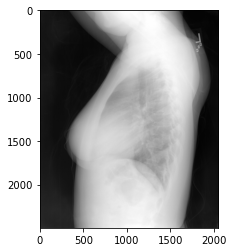

In [9]:
plt.imshow(img)
plt.show()

In [10]:
df2 = pd.read_csv("/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv")
df2.head()

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal


In [11]:
df2.projection.unique()

array(['Frontal', 'Lateral'], dtype=object)

# Build vocab

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow

**Text cleaner**

In [13]:
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))


def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def to_lowercase(text):
    return text.lower()

def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    """
    :param words:
    :type words:
    :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    or
    from spacy.lang.en.stop_words import STOP_WORDS
    :type stop_words:
    :return:
    :rtype:
    """
    return [word for word in words if word not in stop_words]


def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def text2words(text):
    return word_tokenize(text)

def normalize_text( text):
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    #words = text2words(text)
    #stop_words = stopwords.words('english')
    #words = remove_stopwords(words, stop_words)
    #words = stem_words(words)# Either stem ovocar lemmatize
    #words = lemmatize_words(words)
    #words = lemmatize_verbs(words)

    return text
  
def normalize_corpus(corpus):
    return [normalize_text(t) for t in corpus]
  

In [14]:
df['report'] = df[df.columns[1:]].apply(
    lambda x: ','.join(x.astype(str)),
    axis=1
)
df['report'].head()

0    normal,normal,Xray Chest PA and Lateral,Positi...
1    Cardiomegaly/borderline;Pulmonary Artery/enlar...
2    normal,normal,Xray Chest PA and Lateral,rib pa...
3    Pulmonary Disease, Chronic Obstructive;Bullous...
4    Osteophyte/thoracic vertebrae/multiple/small;T...
Name: report, dtype: object

In [15]:
df['report'] = df['report'].apply(normalize_text)

In [16]:
df['report'] = '<start> '+df['report']+' <end>'

In [17]:
num_words = []
for row in df['report'].tolist():
    num_words.append(len(word_tokenize(row)))

In [18]:
num_words= np.array(num_words)
print("min length             : ", num_words.min())
print("max length             : ", num_words.max())
print("50th percentile length : ", np.percentile(num_words,50))
print("75th percentile length : ", np.percentile(num_words,75))
print("90th percentile length : ", np.percentile(num_words,90))
print("95th percentile length : ", np.percentile(num_words,95))
print("98th percentile length : ", np.percentile(num_words,98))
print("98th percentile length : ", np.percentile(num_words,99))


min length             :  11
max length             :  260
50th percentile length :  51.0
75th percentile length :  66.0
90th percentile length :  85.0
95th percentile length :  100.0
98th percentile length :  119.0
98th percentile length :  134.0


In [19]:
vocab_size = 10000
max_len = 260

tok = Tokenizer(num_words=vocab_size,  oov_token='UNK', )
tok.fit_on_texts(df['report'].tolist())

# Merge Images Path

In [20]:
df2 = df2[df2['projection']=='Frontal']

In [21]:
df  =pd.merge(df,df2,  on=['uid'])

In [22]:
df.head()

,uid,MeSH,Problems,image,indication,comparison,findings,impression,report,filename,projection
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,<start> normalnormalxray chest pa and lateralp...,1_IM-0001-4001.dcm.png,Frontal
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,<start> cardiomegalyborderlinepulmonary artery...,2_IM-0652-1001.dcm.png,Frontal
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p...",<start> normalnormalxray chest pa and lateralr...,3_IM-1384-1001.dcm.png,Frontal
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...,<start> pulmonary disease chronic obstructiveb...,4_IM-2050-1001.dcm.png,Frontal
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.,<start> osteophytethoracic vertebraemultiplesm...,5_IM-2117-1003002.dcm.png,Frontal


# Data loader

In [23]:

class det_gen(tensorflow.keras.utils.Sequence):
    'Generates data from a Dataframe'
    def __init__(self,df, tok, max_len,images_path, dim=(256,256), batch_size=8):
        self.df=df
        self.dim = dim
        self.images_path = images_path
        self.tok= tok
        self.max_len = max_len
        self.batch_size = batch_size
        self.nb_iteration = math.ceil((self.df.shape[0])/self.batch_size)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.nb_iteration

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.df=self.df.sample(frac=1)
    
    def load_img(self, img_path):
        
        img = cv2.imread(img_path)
        img =cv2.resize(img,(self.dim))
        
        
        return img
        
    
    def __getitem__(self, index):
        'Generate one batch of data'
        
        indicies = list(range(index*self.batch_size, min((index*self.batch_size)+self.batch_size ,(self.df.shape[0]))))
        
        images = []
        for img_path in self.df['filename'].iloc[indicies].tolist():
            img = self.load_img(os.path.join(self.images_path,img_path))
            images.append(img)
            
            
        
        
        x_batch = self.df['report'].iloc[indicies].tolist()
        
        x_batch_input = [sample[:-len(" <end>")] for sample in x_batch]
        
        x_batch_gt = [sample[len(" <start>"): ] for sample in x_batch]
        
        
        x_batch_input = np.array(pad_sequences( self.tok.texts_to_sequences (x_batch_input),
                          maxlen=self.max_len-1 ,
                          padding='post',
                          truncating='post'))
        
        x_batch_gt = np.array(pad_sequences( self.tok.texts_to_sequences (x_batch_gt),
                          maxlen=self.max_len-1 ,
                          padding='post',
                          truncating='post'))
        
        
        
        
        
        
        return [np.array(images), np.array(x_batch_input)] , np.array(x_batch_gt)   

In [24]:
validation_split= 0.2
df = df.sample(frac=1)
df_train = df.iloc[:-int(df.shape[0]*validation_split)]
df_val   = df.iloc[-int(df.shape[0]*validation_split):]

In [25]:
images_path = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized/"
train_dataloader =  det_gen(df_train, tok, max_len,images_path)
val_dataloader =  det_gen(df_val, tok, max_len,images_path)

In [26]:
[X_img,X_report] ,Y = next(enumerate(train_dataloader))[1]

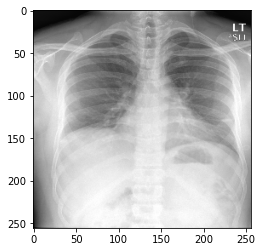

In [27]:
plt.imshow(X_img[0])
plt.show()

In [28]:
print(X_report[0])
print("====================")
print(Y[0])

[  11 5540 5541  521  100 5542   94    9    2    2   78    9  122   27
    4 5543    5   23  179   24   19 1313   20  628   23   70    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

# Build Model

In [29]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [30]:
## Input layers
img_input = layers.Input(shape= (256,256,3)) 
report_input= layers.Input(shape= (max_len-1,))

## Encoder ######################

Densenet_model = tf.keras.applications.DenseNet121(
            include_top=False,
            weights=None,
            input_shape=(256,256,3),
        )
number_of_encoder_layers=  len(Densenet_model.layers)

encoder_output = Densenet_model(img_input)
encoder_output = layers.Flatten()(encoder_output)
encoder_output = layers.Dropout(0.2)(encoder_output)
encoder_output = layers.Dense(512,activation='relu')(encoder_output)

##decoder ########################

#layers
gru_layer =  layers.GRU(512, return_sequences=True)
dense_layer= layers.Dense(vocab_size,activation='softmax')
embedding_layer = layers.Embedding(vocab_size, 300, mask_zero=True)
dropout = layers.Dropout(0.2)

# decoder model
embedding_output = embedding_layer(report_input)
gru_output = gru_layer(embedding_output, initial_state=encoder_output )
gru_output = dropout(gru_output)
output  = dense_layer(gru_output)
model = Model([img_input,report_input ],output)

##Inference models ################

#encoder_inference model
encoder_model = Model(img_input,encoder_output)

#decoder_inference model
prev_hidden_state= layers.Input(shape= (512))
report_input2 = layers.Input(shape= (1,))
embedding_output2= embedding_layer(report_input2)
gru_output2 = gru_layer(embedding_output2, initial_state=prev_hidden_state )
gru_output2 = dropout(gru_output2)
output2 = dense_layer(gru_output2)
decoder_model = Model([report_input2,prev_hidden_state],[output2,gru_output2])

In [31]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
densenet121 (Functional)        (None, 8, 8, 1024)   7037504     input_1[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 65536)        0           densenet121[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 259)]        0                                            
_______________________________________________________________________________________

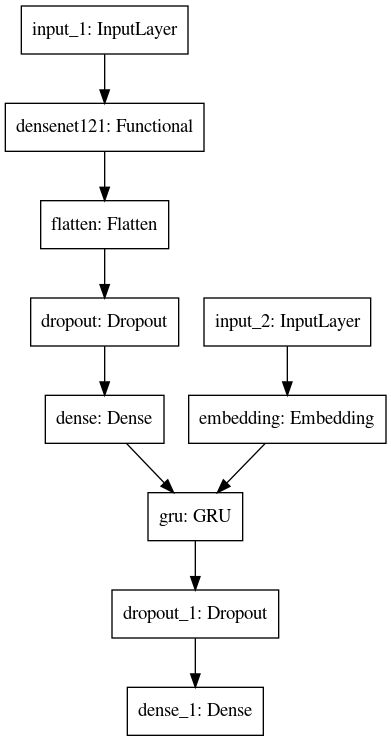

In [32]:
plot_model(model)

In [33]:
epochs =5
lr=1e-3
model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(lr))

In [34]:
hist = model.fit_generator( train_dataloader,
                    validation_data = val_dataloader,
                    epochs = epochs
                )

Epoch 1/5
382/382 [==============================] - 304s 795ms/step - loss: 0.8437 - val_loss: 0.6430
Epoch 2/5
382/382 [==============================] - 197s 516ms/step - loss: 0.5656 - val_loss: 0.5663
Epoch 3/5
382/382 [==============================] - 198s 518ms/step - loss: 0.4714 - val_loss: 0.5319
Epoch 4/5
382/382 [==============================] - 197s 517ms/step - loss: 0.4057 - val_loss: 0.5211
Epoch 5/5
382/382 [==============================] - 197s 516ms/step - loss: 0.3537 - val_loss: 0.5163


In [35]:
import numpy as np
from nltk.translate.bleu_score import corpus_bleu

In [36]:
def tokens_to_text(tokens,tok,end_token='end'):
    sentence=""
    for token in tokens:
        if token ==0:
            break
        
        word = tok.index_word[token]
        
        if word==end_token:
            break
            
        sentence+= word+" "
        
    sentence = sentence.strip()
    
    return sentence


def greedy_inference(input_img, tok,encoder_model, decoder_model,max_len,start_token="start",end_token='end',decoder_type="GRU"):
    if decoder_type=='LSTM':
        a0,c0  =encoder_model(np.expand_dims(input_img,axis=0))
    elif decoder_type=='GRU': 
        hidden_layer  =encoder_model(np.expand_dims(input_img,axis=0))
        
    word = tok.word_index[start_token]
    
    words = []
    
    for index in range(max_len):
        if decoder_type=='LSTM':
            word_probs , a0,c0 = decoder_model.predict([[np.array([word]),a0,c0]])
        elif decoder_type=='GRU': 
            word_probs , hidden_layer = decoder_model.predict([[np.array([word]),hidden_layer]])
            hidden_layer=hidden_layer[0]
        
        word = np.argmax(word_probs)
        
        try:
            if tok.index_word[word]==end_token:
                break
        except:
            pass
        
        words.append(word)
        
    words = tokens_to_text(words,tok)
    return words

In [37]:
def get_predictions_from_data_loader(data_loader,tok,encoder_model, decoder_model,max_len,start_token="start"
                                     ,end_token='end', inference_type='greedy',decoder_type='GRU'):
    
    data_loader_iterator = data_loader.__iter__()
    
    pred_sentences = []
    Gt_sentences = []
    for index, (X,Y) in enumerate(data_loader_iterator):
        for img,_,sample_y in zip(X[0],X[1],Y):
            
            if inference_type=='greedy':
                pred_sentence = greedy_inference(img, tok,encoder_model, decoder_model,max_len,
                                                 start_token="start",end_token='end',decoder_type='GRU')
            
            GT_sentence   = tokens_to_text(sample_y,tok)
            
            pred_sentences.append(pred_sentence)
            Gt_sentences.append(GT_sentence)
        
        if index == data_loader.nb_iteration -1:
            break
        print("Done with batch number: {} ", index)
        
    return Gt_sentences, pred_sentences

In [38]:
def calculate_bleu_evaluation(GT_sentences, predicted_sentences):
    BLEU_1 = corpus_bleu(GT_sentences, predicted_sentences, weights=(1.0, 0, 0, 0))
    BLEU_2 = corpus_bleu(GT_sentences, predicted_sentences, weights=(0.5, 0.5, 0, 0))
    BLEU_3 = corpus_bleu(GT_sentences, predicted_sentences, weights=(0.3, 0.3, 0.3, 0))
    BLEU_4 = corpus_bleu(GT_sentences, predicted_sentences, weights=(0.25, 0.25, 0.25, 0.25))
    
    return BLEU_1,BLEU_2,BLEU_3,BLEU_4

In [39]:
def evaluate_from_dataloader(data_loader,tok,encoder_model, decoder_model,max_len,start_token="start",end_token='end', inference_type='greedy',decoder_type="GRU"):
    Gt_sentences, pred_sentences = get_predictions_from_data_loader(data_loader,tok,encoder_model, decoder_model,max_len,start_token=start_token,end_token=end_token, inference_type=inference_type,decoder_type=decoder_type)
    BLEU_1,BLEU_2,BLEU_3,BLEU_4 = calculate_bleu_evaluation(Gt_sentences, pred_sentences)
    
    return BLEU_1,BLEU_2,BLEU_3,BLEU_4

In [40]:
BLEU_1,BLEU_2,BLEU_3,BLEU_4 =  evaluate_from_dataloader(val_dataloader,tok,encoder_model, decoder_model,max_len)
print(BLEU_1)
print('-------')
print(BLEU_2)
print('-------')
print(BLEU_3)
print('-------')
print(BLEU_4)

Done with batch number: {}  0
Done with batch number: {}  1
Done with batch number: {}  2
Done with batch number: {}  3
Done with batch number: {}  4
Done with batch number: {}  5
Done with batch number: {}  6
Done with batch number: {}  7
Done with batch number: {}  8
Done with batch number: {}  9
Done with batch number: {}  10
Done with batch number: {}  11
Done with batch number: {}  12
Done with batch number: {}  13
Done with batch number: {}  14
Done with batch number: {}  15
Done with batch number: {}  16
Done with batch number: {}  17
Done with batch number: {}  18
Done with batch number: {}  19
Done with batch number: {}  20
Done with batch number: {}  21
Done with batch number: {}  22
Done with batch number: {}  23
Done with batch number: {}  24
Done with batch number: {}  25
Done with batch number: {}  26
Done with batch number: {}  27
Done with batch number: {}  28
Done with batch number: {}  29
Done with batch number: {}  30
Done with batch number: {}  31
Done with batch nu

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.06288483889314771
-------
0.25076849661220946
-------
0.4360776069747315
-------
0.5007679069311546
